In [1]:
import calendar
import json

import matplotlib
import networkx as nx
import numpy as np
import pandas as pd
import requests
import unidecode
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

In [2]:
# Download dataset from Kaggle (registration required): https://www.kaggle.com/Cornell-University/arxiv/download
filepath = 'arxiv-metadata-oai-snapshot.json'

In [3]:
# The file is made of json objects separated by a line
# This procedure allows us to read only what we need (as opposed to the entire file)
# Set to -1 if you want to read the entire file
max_lines = -1

lines = []
with open(filepath) as file:
    i = 0
    while max_lines < 0 or i < max_lines:
        line = file.readline()
        if not line:
            break
        lines.append(json.loads(line))
        i += 1

print("Read %s publications." % len(lines))

Read 1796911 publications.


In [4]:
# The data can be stored in a dataframe right away
df = pd.DataFrame(lines).set_index("id")
df.update_date = pd.to_datetime(df.update_date, infer_datetime_format=True)
df.head(3)

,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
id,,,,,,,,,,,,,
0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"


In [5]:
# Group by a 30-day window (which models a month)
grouper_month = pd.Grouper(key="update_date", freq="30D")
# Group by year
grouper_year = pd.Grouper(key="update_date", freq="Y")

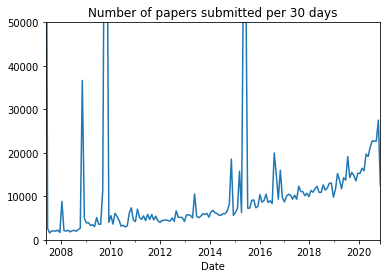

In [6]:
df.groupby(grouper_month).title.count().plot(legend=None)
plt.ylim(bottom=0, top=50000)
plt.title("Number of papers submitted per 30 days")
plt.xlabel("Date")
plt.show()

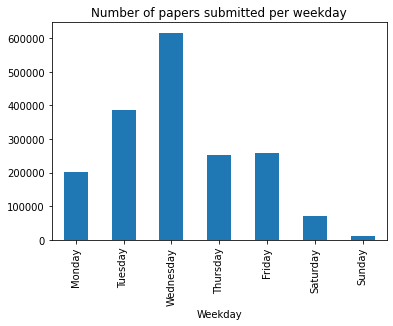

In [7]:
df.groupby(df.update_date.dt.weekday).title.count().sort_index().plot.bar()
plt.title("Number of papers submitted per weekday")
plt.xlabel("Weekday")
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda wd, p: calendar.day_name[wd]))
plt.show()

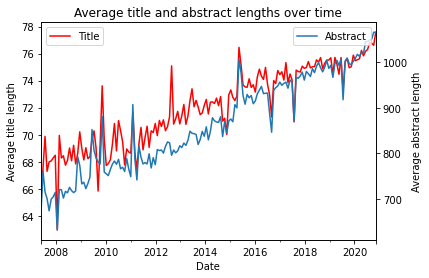

In [8]:
agg_lengths = df.assign(title_len=df.title.str.len(), abstract_len=df.abstract.str.len()) \
                .groupby(grouper_month).mean()
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
agg_lengths.title_len.plot(ax=ax0, color="red", label="Title")
agg_lengths.abstract_len.plot(ax=ax1, label="Abstract")
ax0.legend(loc=0)
ax0.set_ylabel("Average title length")
ax1.legend(loc=1)
ax1.set_ylabel("Average abstract length")
plt.title("Average title and abstract lengths over time")
ax0.set_xlabel("Date")
plt.show()

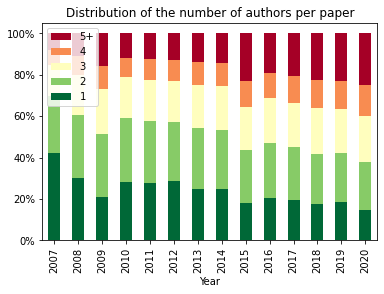

In [9]:
agg_authors = df[["update_date"]].assign(authors_len=df.authors_parsed.str.len())
agg_authors = agg_authors[agg_authors.authors_len > 0]
authors_buckets = 5
for i in range(1, authors_buckets):
    agg_authors[i] = agg_authors.authors_len == (i)
agg_authors["%s+" % authors_buckets] = agg_authors.authors_len >= authors_buckets
del agg_authors["authors_len"]
agg_authors_cat = agg_authors.groupby(grouper_year).mean()

agg_authors_cat.plot.bar(stacked=True, colormap='RdYlGn_r')
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FixedFormatter(agg_authors_cat.index.strftime('%Y')))
handles, labels = plt.gca().get_legend_handles_labels()
plt.gca().legend(handles[::-1], labels[::-1], loc='upper left')
plt.xlabel("Year")
plt.title("Distribution of the number of authors per paper")
plt.show()

In [10]:
# We compute a low-dimensionality representation of the abstracts

vectorizer = TfidfVectorizer(stop_words="english")
abstracts_sparse = vectorizer.fit_transform(df.abstract)

n_components = 10

svd = TruncatedSVD(n_components=n_components, random_state=1)
abstracts_svd = svd.fit_transform(abstracts_sparse)

print(abstracts_sparse.shape)
print(abstracts_svd.shape)

(1796911, 579938)
(1796911, 10)


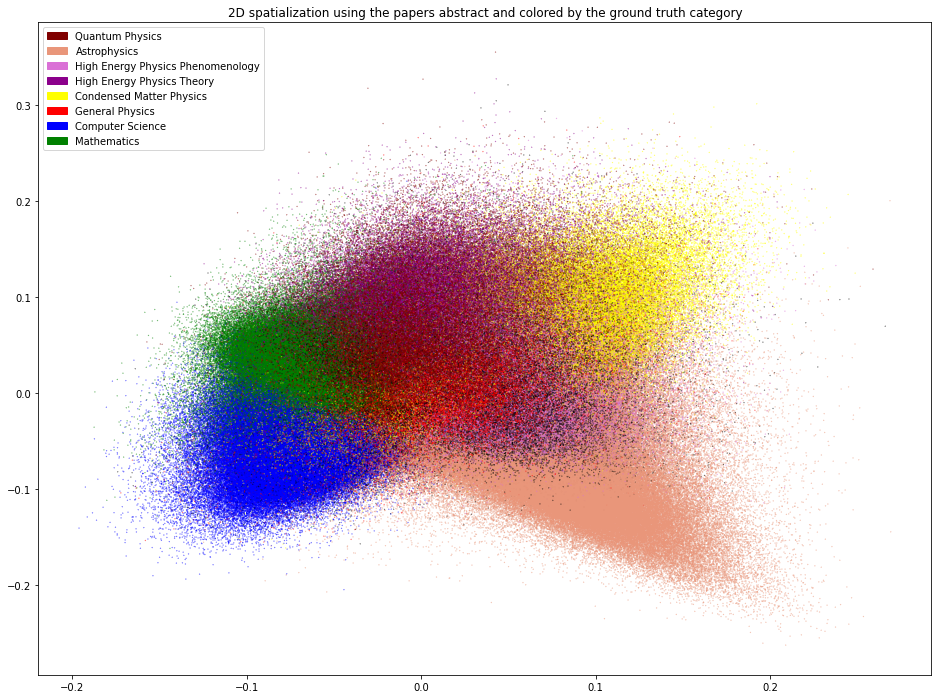

In [11]:
abstracts_2d = PCA(n_components=2).fit_transform(abstracts_svd)

categories = [
    ("quant-ph", "maroon", "Quantum Physics"),
    ("astro-ph", "darksalmon", "Astrophysics"),
    ("hep-ph", "orchid", "High Energy Physics Phenomenology"),
    ("hep-th", "darkmagenta", "High Energy Physics Theory"),
    ("cond-mat", "yellow", "Condensed Matter Physics"),
    ("physics", "red", "General Physics"),
    ("cs", "blue", "Computer Science"),
    ("math", "green", "Mathematics")
]
default_color = "black"

def category_color(category):
    for keyword, color, _ in categories:
        if keyword in category:
            return color
    return default_color

plt.figure(figsize=(16, 12))
plt.legend(handles=[matplotlib.patches.Patch(color=color, label=label) for _, color, label in categories])
plt.scatter(abstracts_2d[:, 0], abstracts_2d[:, 1], s=0.05, c=df.categories.apply(category_color))
plt.title("2D spatialization using the papers abstract and colored by the ground truth category")
plt.show()